In [1]:
# 导入库，设定超参数
# coding=utf-8
from __future__ import absolute_import, division, print_function

import os
import random
import numpy as np

import torch
import torch.distributed as dist

from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
try:
    from apex import amp
    from apex.parallel import DistributedDataParallel as DDP
    has_apex = True
except ImportError:
    has_apex = False
    # raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")

from models.modeling import VisionTransformer, CONFIGS
from utils.data_utils import get_loader
from utils.dist_util import *
from matplotlib import pyplot as plt
from analyse.cca_core import *
from analyse.pwcca import *

Head_Num = 12
def _plot_helper(arr, label=None, xlabel=None, ylabel=None):
    if label is not None:
        plt.plot(arr, lw=2.0, label=label)
        plt.legend(loc="best")
    else:
        plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

/home/zijie_xin/anaconda3/envs/env_lxmert/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 确定GPU设备和model，并load参数
# Setup CUDA, GPU & distributed training
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if n_gpu > 0:
    torch.cuda.manual_seed_all(seed)

def build_model(head_num):
    # Model & Tokenizer Setup
    config = CONFIGS["ViT-B_16-h"+str(head_num)]
    num_classes = 100
    # 可视化参数设为True
    model = VisionTransformer(config, 224, zero_head=True, num_classes=num_classes, vis=True)

    PATH = "logs/cifar100/cifar100-b16h"+str(head_num)+"/cifar100-b16h"+str(head_num)+"-Latest-epoch10.pth"
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model'])
    model.cuda()
    epoch = checkpoint['epoch']
    max_accuracy = checkpoint['max_accuracy']
    print("Load model from %s, epoch %d, max_accuracy %f" % (PATH, epoch, max_accuracy))
    return model

model = build_model(head_num=Head_Num)

Load model from logs/cifar100/cifar100-b16h12/cifar100-b16h12-Latest-epoch10.pth, epoch 10, max_accuracy 92.460000


In [3]:
# 加载data
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, RandomSampler, DistributedSampler, SequentialSampler

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),  # (args.img_size, args.img_size)
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

testset = datasets.CIFAR100(root="./data", # args.data_path,
                            train=False,
                            download=True,
                            transform=transform_test)

# len(testset) = 10000
test_loader = DataLoader(testset,
                        sampler=SequentialSampler(testset),
                        batch_size=24, #?args.eval_batch_size,
                        num_workers=1,
                        pin_memory=True)
# len(test_loader) = 10000/batch_size = 625

# model运行data生成att_mats
model.eval()
for iter, (images, target) in enumerate(test_loader):
    if iter > 0:
        break
    images = images.cuda()
    target = target.cuda()
    output, att_mats = model(images)

print(type(att_mats))
print("Testset length: ", len(att_mats))
print("Tensor shape: ", att_mats[0].shape)

Files already downloaded and verified
<class 'list'>
Testset length:  12
Tensor shape:  torch.Size([24, 12, 197, 197])


In [4]:
# w = np.zeros((12, head_num, 1, 197*197))  # w[i, j]表示第i个layer的第j个head的attention score
# for i, att_mat in enumerate(att_mats):
#     # mean: [bs, head_num, 197, 197] -> [head_num, 197, 197]
#     att_mat = torch.mean(att_mat, dim=0)
#     # reshape: [head_num, 197, 197] -> [head_num, 197*197]
#     att_mat = att_mat.reshape(head_num, -1).unsqueeze(-2)
#     w[i] = att_mat.cpu().detach().numpy()


# w[i, j]表示第i个layer的第j个head的attention score
w_h2 = np.zeros((12, 2, 197*197))
w_h4 = np.zeros((12, 4, 197*197))
w_h8 = np.zeros((12, 8, 197*197))
w_h12 = np.zeros((12, 12, 197*197))
w_h16 = np.zeros((12, 16, 197*197))
w_h32 = np.zeros((12, 32, 197*197))

w_matrix = {
    2: w_h2,
    4: w_h4,
    8: w_h8,
    12: w_h12,
    16: w_h16,
    32: w_h32,
}
def build_w(head_num):
    w = w_matrix[head_num]
    for i, att_mat in enumerate(att_mats):
        # mean: [bs, head_num, 197, 197] -> [head_num, 197, 197]
        att_mat = torch.mean(att_mat, dim=0)
        # reshape: [head_num, 197, 197] -> [head_num, 197*197]
        att_mat = att_mat.reshape(head_num, -1)
        w[i] = att_mat.cpu().detach().numpy()

build_w(head_num=Head_Num)

对每一层的head0,1计算平均相似度，发现随着层数的加深，相似度在明显减少。

说明层数越深，多头拆分出的feature层次越高，越抽象，多头之间越diversify

In [5]:
def all_cca(layer1, head1, layer2, head2, draw=True, isprint=True, head_num=12):
    print("head_num=", head_num)
    w = w_matrix[head_num]
    acts1, acts2 = w[layer1, head1][np.newaxis, :], w[layer2, head2][np.newaxis, :]
    # acts1, acts2 = w[layer1, head1], w[layer2, head2]
    # print("activation shapes", acts1.shape, acts2.shape)  # [1, 197*197]
    results = get_cca_similarity(acts1, acts2, epsilon=1e-10, verbose=False)
    if draw:
        _plot_helper(results["cca_coef1"], "all_L%d" % (layer1), "CCA Coef idx", "CCA coef value")
    if isprint:
        print("W[%d, %d] and W[%d, %d] Mean all_CCA similarity %f" % (layer1, head1, layer2, head2, np.mean(results["cca_coef1"])))
    return np.mean(results["cca_coef1"])

$\text{cos sim}=\dfrac{\vec{a}\cdot\vec{b}}{|\vec{a}|\cdot |\vec{b}|}\in [-1, 1] $

$\text{w[layer, head]}\in [1, 197*197]$ 

In [6]:
import torch.nn.functional as F
def cos_sim(layer1, head1, layer2, head2, isprint=True, head_num=12):
    print("head_num=", head_num)
    w = w_matrix[head_num]
    vec1, vec2 = w[layer1, head1], w[layer2, head2]
    # print("activation shapes", vec1.shape, vec2.shape)
    cos_sim = vec1.dot(vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2))
    if isprint:
        print("W[%d, %d] and W[%d, %d] cos similarity %f" % (layer1, head1, layer2, head2, cos_sim))
    return cos_sim

针对某些层的12个head对应的投影W互相之间的相似度进行可视化

head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12

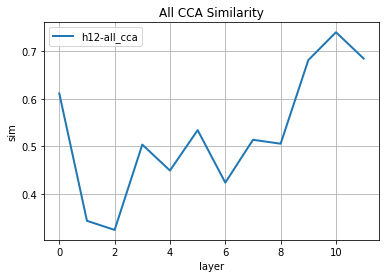

head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12
head_num= 12

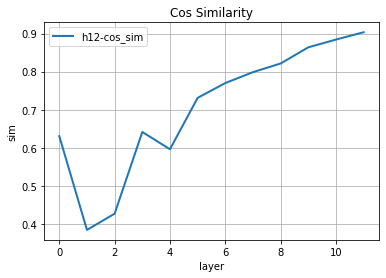

In [7]:
def layer_sim(type="all_cca", head_num=12):
    sim = []
    for layer in range(12):
        sims = np.zeros((head_num, head_num))
        sum = 0.0
        for i in range(head_num):
            for j in range(head_num):
                if i == j:
                    continue
                if type == "all_cca":
                    sims[i, j] = all_cca(layer, i, layer, j, draw=False, isprint=False, head_num=head_num)
                elif type == "cos_sim":
                    sims[i, j] = cos_sim(layer, i, layer, j, isprint=False, head_num=head_num)
                sum += sims[i, j]
        sim.append(sum / (head_num * head_num - head_num))
    print(sim)
    _plot_helper(sim, 'h'+str(head_num)+'-'+type, "layer", "sim")

all_sim_2 = [0.8242705475909007, 0.761484351257135, 0.7019077249183547, 0.6349758384195053, 0.5975709181606883, 0.8703015049949007, 0.7432890097427606, 0.8232664689448728, 0.9247473907051988, 0.8034807880284234, 0.8708054490089727, 0.8488162607406422]
all_sim_4 = [0.6472901918581336, 0.48637036690895596, 0.5672633609943977, 0.5749959964494837, 0.45202116923963526, 0.7302000396929212, 0.48754279417325397, 0.6782090863315605, 0.6623954943402052, 0.6391951858865447, 0.8036643931495329, 0.857762066907623]
all_sim_8 = [0.5566642576825301, 0.48091535261023355, 0.4077979248952013, 0.47930357394166023, 0.46075289162667865, 0.6485234843678351, 0.5329375148778783, 0.6744388005997448, 0.7018324767516658, 0.6852598343924939, 0.7946211534391607, 0.6835898594411369]
all_sim_12 = [0.6067708316359305, 0.38614524986503773, 0.36838009312168357, 0.5284635786806215, 0.46920286220834917, 0.5385408565787889, 0.4523725039563946, 0.5378921151771806, 0.5206455860600394, 0.6845207465885635, 0.7261096029441427, 0.6475010526619257]
all_sim_16 = [0.5249058785970778, 0.4085511344878498, 0.40434877551012227, 0.5404727638095226, 0.5018140168868753, 0.570120509129456, 0.44763375810789885, 0.5627550840436999, 0.5708017992587936, 0.5475384487119919, 0.6424357265049817, 0.5673782301783262]
all_sim_32 = [0.5045014321884653, 0.40478031012115895, 0.35964295855797995, 0.49553376759478107, 0.4621031635114591, 0.511644126990101, 0.40126464842581827, 0.4720133547369376, 0.44775153492851216, 0.35861299989329054, 0.4199254086465085, 0.44369804214502906]

layer_sim(type="all_cca", head_num=Head_Num)
type = "all_cca"
# _plot_helper(all_sim_2, 'h'+str(2)+'-'+type, "layer", "sim")
# _plot_helper(all_sim_4, 'h'+str(4)+'-'+type, "layer", "sim")
# _plot_helper(all_sim_8, 'h'+str(8)+'-'+type, "layer", "sim")
# _plot_helper(all_sim_12, 'h'+str(12)+'-'+type, "layer", "sim")
# _plot_helper(all_sim_16, 'h'+str(16)+'-'+type, "layer", "sim")
# _plot_helper(all_sim_32, 'h'+str(32)+'-'+type, "layer", "sim")
plt.grid()
plt.title("All CCA Similarity")
plt.show()


cos_sim_2 = [0.7931566097600506, 0.7857765666824164, 0.7395327629727291, 0.772952931637024, 0.7091143902539352, 0.9208100588259234, 0.8754686047520948, 0.9200070123870867, 0.9600341613138532, 0.8862761858692667, 0.9246875442591009, 0.9375914354073902]
cos_sim_4 = [0.6807583443064865, 0.5048166264969268, 0.6049282477361261, 0.7188862556491507, 0.6022284589674867, 0.8262228054203138, 0.7739741555962739, 0.856918155209657, 0.8704948951556742, 0.8626040300811596, 0.8898706386133914, 0.9331824930975668]
cos_sim_8 = [0.5843850640031489, 0.5028130497852273, 0.47787984824853663, 0.6285025101287891, 0.6139482011887584, 0.7787597020776535, 0.7782464091007454, 0.8273417120347304, 0.8533126188171082, 0.845391893947029, 0.8727186497110254, 0.8887051977017965]
cos_sim_12 = [0.6302125968731721, 0.42579546146070185, 0.4619231169068254, 0.6567020982570281, 0.6151224974601415, 0.732422450889731, 0.764737207865037, 0.7842751746355154, 0.8079912625302963, 0.8485632252103609, 0.8641220307836529, 0.8831417374950995]
cos_sim_16 = [0.5633531961044356, 0.4445476320555915, 0.5036344756091218, 0.677765735908409, 0.6379161598775557, 0.7719182847347131, 0.7677774685421416, 0.8230960691422864, 0.8466996431140479, 0.8429357447914257, 0.8546605947547686, 0.8835090219453515]
cos_sim_32 = [0.5617150085068258, 0.459323825061354, 0.4843322257025956, 0.6728930815590813, 0.6252643644674711, 0.7534741758521422, 0.7769167284675074, 0.8046823568217293, 0.8253970698739602, 0.8240840409442464, 0.8123466851842719, 0.8763336212399095]
layer_sim(type="cos_sim", head_num=Head_Num)
type = "cos_sim"
# _plot_helper(cos_sim_2, 'h'+str(2)+'-'+type, "layer", "sim")
# _plot_helper(cos_sim_4, 'h'+str(4)+'-'+type, "layer", "sim")
# _plot_helper(cos_sim_8, 'h'+str(8)+'-'+type, "layer", "sim")
# _plot_helper(cos_sim_12, 'h'+str(12)+'-'+type, "layer", "sim")
# _plot_helper(cos_sim_16, 'h'+str(16)+'-'+type, "layer", "sim")
# _plot_helper(cos_sim_32, 'h'+str(32)+'-'+type, "layer", "sim")
plt.grid()
plt.title("Cos Similarity")
plt.show()